# Collection 3 GQA investigation

In [ ]:
import datacube
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

# Connect to datacube
dc = datacube.Datacube()

# Load world map for map overlay
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres')).to_crs('EPSG:4326')


# Function for summarising GQA values per region code
def summarise_gqa(dss):
    
    # Extract region code and GQA metadata
    fields = ("region_code", "gqa_iterative_mean_xy")
    metadata_df = pd.DataFrame({k: i.metadata.fields[k] for k in fields} for i in dss)
    metadata_df["region_code"] = metadata_df["region_code"].astype(str)
    metadata_df = metadata_df.set_index("region_code")

    # Identify fields with valid GQA
    metadata_df["gqa_valid"] = ~metadata_df.gqa_iterative_mean_xy.isna()
    metadata_df["gqa_less_1"] = metadata_df.gqa_iterative_mean_xy < 1

    # Summarise percent of observations per region code with valid GQA
    metadata_df_summary = metadata_df[['gqa_valid', 'gqa_less_1']].groupby("region_code").mean()
    return metadata_df_summary



## Summarise GQA availability for Landsat path/rows
Calculate:

* The % of satellite scenes with valid GQA values
* The % of satellite scenes with small GQA values (< 1.0)

In the plot of % of satellite scenes with valid GQA values below, data from any red cells will be lost completely if any GQA filter is applied.

For Landsat this occurs only over ocean, which is less likely to have issue on downstream processing.

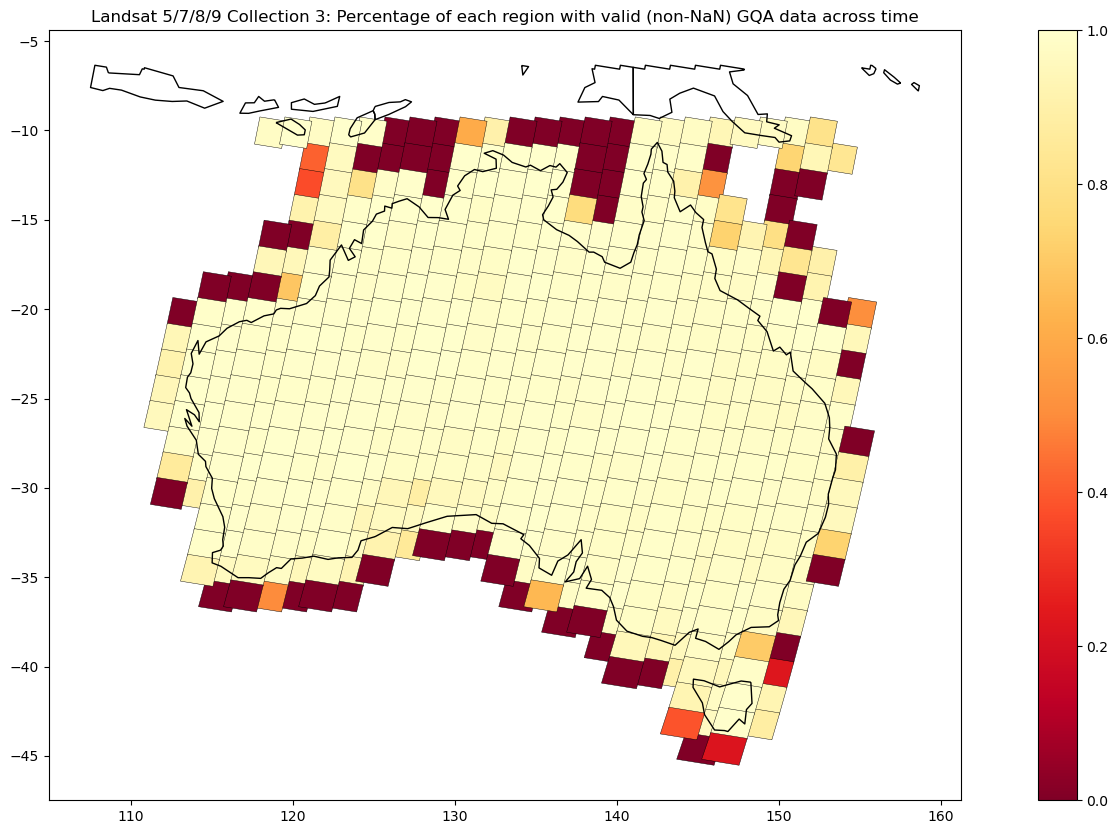

In [2]:
# Load Landsat metadata
dss = dc.find_datasets_lazy(product=["ga_ls5t_ard_3", "ga_ls7e_ard_3", "ga_ls8c_ard_3", "ga_ls9c_ard_3"])

# Summarise GQA per region
metadata_df_summary = summarise_gqa(dss)

# Join results to Landsat path/rows
grid_gdf = gpd.read_file('https://data.dea.ga.gov.au/derivative/ga_ls_path_row_grid.geojson')
grid_gdf.index = grid_gdf.PR.astype(str).str.zfill(6).rename('region_code')
gqa_gdf = grid_gdf.join(metadata_df_summary)

# Export to file
gqa_gdf.to_file('landsat_gqa.geojson')

# Plot
fig, ax = plt.subplots(figsize=(20, 10))
gqa_gdf.plot(ax=ax, column='gqa_valid', vmin=0.0, vmax=1.0, edgecolor='black', linewidth=0.3, cmap='YlOrRd_r', legend=True)
world.clip(gqa_gdf).plot(facecolor="none", ax=ax)
plt.title('Landsat 5/7/8/9 Collection 3: Percentage of each region with valid (non-NaN) GQA data across time');

## Summarise GQA for Sentinel-2 MGRS tiles

In the plot of % of satellite scenes with valid GQA values below, data from any red cells will be lost completely if any GQA filter is applied. 


For Sentinel-2, this happens in some areas that intersect with Australia (e.g. along the coastline in Sydney, Gold Coast etc), which means these locations will not be processed in any workflow filtering by GQA.

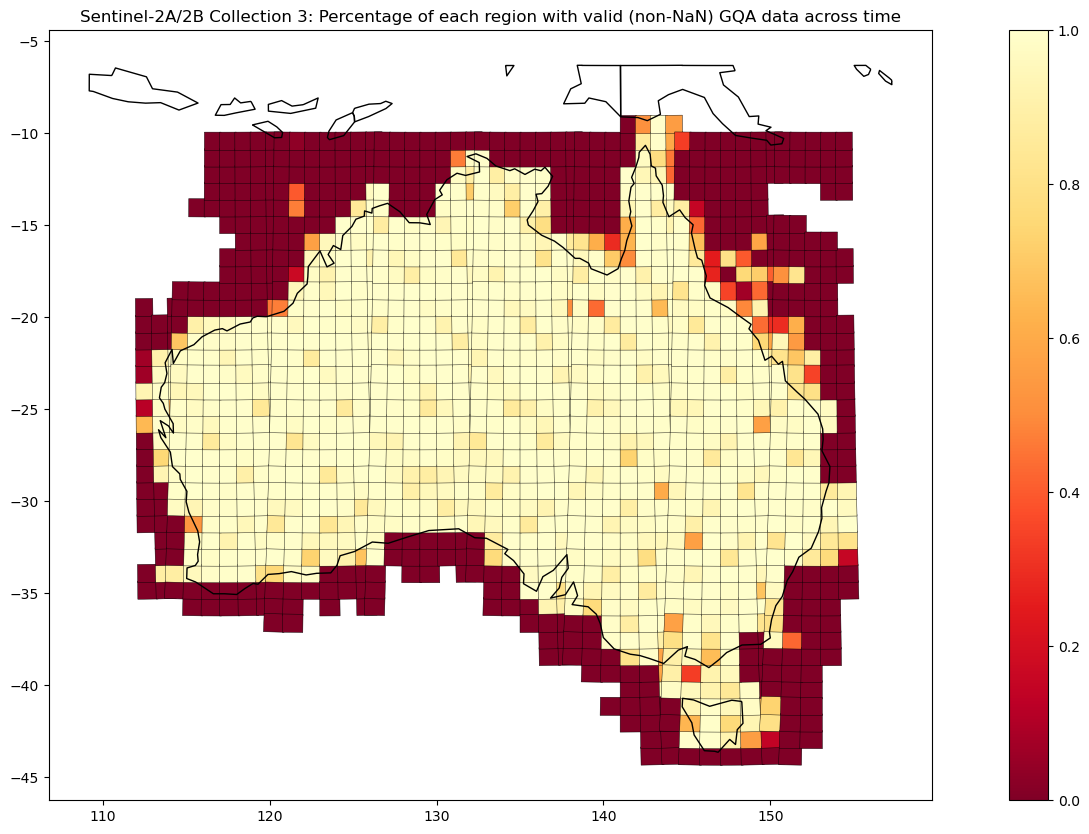

In [3]:
# Load Sentinel-2 metadata
dss = dc.find_datasets_lazy(product=["ga_s2am_ard_3", "ga_s2bm_ard_3"])

# Summarise GQA per region
metadata_df_summary = summarise_gqa(dss)

# Join results to Sentinel-2 MGRS tiles
grid_gdf = gpd.read_file('https://data.dea.ga.gov.au/derivative/ga_s2_mgrs_tile_grid.geojson')
grid_gdf.index = grid_gdf.Name.astype(str).rename('region_code')
gqa_gdf = grid_gdf.join(metadata_df_summary)

# Export to file
gqa_gdf.to_file('sentinel2_gqa.geojson')

# Plot
fig, ax = plt.subplots(figsize=(20, 10))
gqa_gdf.plot(ax=ax, column='gqa_valid', vmin=0.0, vmax=1.0, edgecolor='black', linewidth=0.3, cmap='YlOrRd_r', legend=True)
world.clip(gqa_gdf).plot(facecolor="none", ax=ax)
plt.title('Sentinel-2A/2B Collection 3: Percentage of each region with valid (non-NaN) GQA data across time');

## Export GCP points as vector file

In [ ]:
# !unzip Fix_QA_points.zip -d GCP_points

In [ ]:
# import pandas as pd
# import geopandas as gpd
# import glob

# all_files = glob.glob('GCP_points/Fix_QA_points/*/*/*.txt')
# all_files_clean = [i for i in all_files if 'old' not in i]

# dfs = [pd.read_csv(file, header=None) for file in all_files_clean]
# df = pd.concat(dfs)
# df.columns = ['y', 'x']

# gpd.GeoDataFrame(geometry=gpd.points_from_xy(x=df.x, y=df.y), crs='EPSG:4326').to_file('gcp_points.geojson')
